In [32]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

REBUILD_DATA = False #set to true to once, then back to false unless you want to change something in your training data

class CovidvsNormal():
    IMG_SIZE = 80
    NORMAL = "NORMAL"
    COVID = "COVID-19"
    LABELS = {NORMAL:0, COVID:1}
    
    training_data = []
    normalcount = 0
    covidcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "png" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.NORMAL:
                            self.normalcount += 1
                        elif label == self.COVID:
                            self.covidcount += 1
                    except Exception as e:
                        pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("NORMAL:", self.normalcount)
        print("COVID:", self.covidcount)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) #input image, 32 convolutional features, 5*5 kernel
        self.conv2 = nn.Conv2d(32, 64, 5 )
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(80,80).view(-1, 1, 80, 80)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 4608)
        self.fc2 = nn.Linear(4608, 2)
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            print(self._to_linear)
        return x
        
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")    
    
net = Net().to(device)

if REBUILD_DATA:
    covidvnormal = CovidvsNormal()
    covidvnormal.make_training_data()

training_data = np.load("training_data.npy")
print(len(training_data))

running on the GPU
torch.Size([128, 6, 6])
4608
1560


In [44]:
import matplotlib.pyplot as plt

plt.imshow(training_data[0][0].view( 80,80))

AttributeError: module 'numpy' has no attribute 'training_data'

In [41]:
type(training_data)
training_data

array([[array([[48, 62, 72, ..., 31, 27, 13],
       [50, 60, 67, ..., 29, 22,  7],
       [48, 56, 65, ..., 26, 18,  3],
       ...,
       [ 0,  0, 15, ...,  0,  0,  0],
       [ 0,  0, 18, ...,  0,  0,  0],
       [ 0,  0, 20, ...,  0,  0,  0]], dtype=uint8),
        array([1., 0.])],
       [array([[39, 70, 80, ...,  0,  0,  0],
       [34, 63, 81, ...,  0,  0,  0],
       [37, 67, 80, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
        array([1., 0.])],
       [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
        array([0., 1.])],
       ...,
       [array([[  4,   4,   4, ...,   0,   2,   1],
       [  1,   0,   0, ...,   2,   0,   0],
       [  1,   1,   1, ...,  12,  11,   4],
       ...,
     

156
1404
156


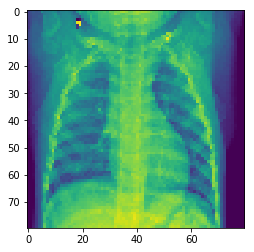

In [47]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 80, 80)
X = X/255.0 
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))
import matplotlib.pyplot as plt

plt.imshow(X[0].view(80,80))

In [49]:
BATCH_SIZE = 8
EPOCHS = 10
def train(net):
    import torch.optim as optim
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    loss_function = nn.BCELoss()
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            #print(i, i+BATCH_SIZE)
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,80,80)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch}. Loss:{loss}")
              
train(net)

  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▍                                                                                | 3/176 [00:00<00:06, 26.39it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  3%|██▊                                                                               | 6/176 [00:00<00:06, 24.70it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  5%|████▏                                                                             | 9/176 [00:00<00:06, 24.15it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  7%|█████▌                                                                           | 12/176 [00:00<00:06, 24.73it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  9%|██████▉                                                                          | 15/176 [00:00<00:06, 24.69it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 10%|████████▎                                                                        | 18/176 [00:00<00:06, 24.86it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 12%|█████████▋                                                                       | 21/176 [00:00<00:06, 23.60it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████                                                                      | 24/176 [00:01<00:07, 19.53it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 15%|███████████▉                                                                     | 26/176 [00:01<00:08, 17.22it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 16%|█████████████▎                                                                   | 29/176 [00:01<00:07, 18.99it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 18%|██████████████▋                                                                  | 32/176 [00:01<00:07, 20.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 20%|████████████████                                                                 | 35/176 [00:01<00:06, 22.06it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 22%|█████████████████▍                                                               | 38/176 [00:01<00:05, 23.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 23%|██████████████████▊                                                              | 41/176 [00:01<00:05, 23.73it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 25%|████████████████████▎                                                            | 44/176 [00:01<00:05, 24.23it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 27%|█████████████████████▋                                                           | 47/176 [00:02<00:05, 24.84it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 28%|███████████████████████                                                          | 50/176 [00:02<00:04, 25.56it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 30%|████████████████████████▍                                                        | 53/176 [00:02<00:04, 26.07it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 32%|█████████████████████████▊                                                       | 56/176 [00:02<00:04, 26.44it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 34%|███████████████████████████▏                                                     | 59/176 [00:02<00:04, 26.70it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 35%|████████████████████████████▌                                                    | 62/176 [00:02<00:04, 26.45it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 37%|█████████████████████████████▉                                                   | 65/176 [00:02<00:04, 25.15it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 39%|███████████████████████████████▎                                                 | 68/176 [00:02<00:04, 26.38it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 40%|████████████████████████████████▋                                                | 71/176 [00:02<00:03, 27.12it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 42%|██████████████████████████████████                                               | 74/176 [00:03<00:03, 27.79it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 44%|███████████████████████████████████▍                                             | 77/176 [00:03<00:03, 28.31it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 45%|████████████████████████████████████▊                                            | 80/176 [00:03<00:03, 28.49it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 47%|██████████████████████████████████████▏                                          | 83/176 [00:03<00:03, 28.66it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 49%|███████████████████████████████████████▌                                         | 86/176 [00:03<00:03, 28.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 51%|████████████████████████████████████████▉                                        | 89/176 [00:03<00:03, 26.61it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|██████████████████████████████████████████▎                                      | 92/176 [00:03<00:03, 27.34it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 54%|███████████████████████████████████████████▋                                     | 95/176 [00:03<00:02, 27.99it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 56%|█████████████████████████████████████████████▌                                   | 99/176 [00:03<00:02, 28.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 58%|██████████████████████████████████████████████▎                                 | 102/176 [00:04<00:02, 28.97it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 60%|███████████████████████████████████████████████▋                                | 105/176 [00:04<00:02, 29.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 61%|█████████████████████████████████████████████████                               | 108/176 [00:04<00:02, 29.26it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 64%|██████████████████████████████████████████████████▉                             | 112/176 [00:04<00:02, 28.18it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 65%|████████████████████████████████████████████████████▎                           | 115/176 [00:04<00:02, 28.16it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 67%|█████████████████████████████████████████████████████▋                          | 118/176 [00:04<00:02, 28.42it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 69%|███████████████████████████████████████████████████████                         | 121/176 [00:04<00:01, 28.17it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 70%|████████████████████████████████████████████████████████▎                       | 124/176 [00:04<00:01, 28.59it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 72%|█████████████████████████████████████████████████████████▋                      | 127/176 [00:04<00:01, 28.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 74%|███████████████████████████████████████████████████████████▌                    | 131/176 [00:05<00:01, 28.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 77%|█████████████████████████████████████████████████████████████▎                  | 135/176 [00:05<00:01, 29.13it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 79%|███████████████████████████████████████████████████████████████▏                | 139/176 [00:05<00:01, 29.46it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 81%|█████████████████████████████████████████████████████████████████               | 143/176 [00:05<00:01, 29.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 84%|██████████████████████████████████████████████████████████████████▊             | 147/176 [00:05<00:00, 29.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 85%|████████████████████████████████████████████████████████████████████▏           | 150/176 [00:05<00:00, 29.45it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 87%|█████████████████████████████████████████████████████████████████████▌          | 153/176 [00:05<00:00, 29.29it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 89%|██████████████████████████████████████████████████████████████████████▉         | 156/176 [00:05<00:00, 29.43it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 90%|████████████████████████████████████████████████████████████████████████▎       | 159/176 [00:05<00:00, 29.54it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████      | 163/176 [00:06<00:00, 29.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 94%|███████████████████████████████████████████████████████████████████████████▍    | 166/176 [00:06<00:00, 27.55it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 96%|████████████████████████████████████████████████████████████████████████████▊   | 169/176 [00:06<00:00, 26.83it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 172/176 [00:06<00:00, 26.51it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 99%|███████████████████████████████████████████████████████████████████████████████▌| 175/176 [00:06<00:00, 25.76it/s]

torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:06<00:00, 26.46it/s]


Epoch: 0. Loss:0.00689387833699584


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▍                                                                                | 3/176 [00:00<00:06, 27.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  3%|██▊                                                                               | 6/176 [00:00<00:06, 27.39it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  5%|████▏                                                                             | 9/176 [00:00<00:06, 27.53it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  7%|█████▌                                                                           | 12/176 [00:00<00:05, 27.74it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  9%|██████▉                                                                          | 15/176 [00:00<00:05, 27.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 10%|████████▎                                                                        | 18/176 [00:00<00:05, 27.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 12%|█████████▋                                                                       | 21/176 [00:00<00:06, 25.66it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████                                                                      | 24/176 [00:00<00:06, 23.24it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 15%|████████████▍                                                                    | 27/176 [00:01<00:06, 24.01it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 17%|█████████████▊                                                                   | 30/176 [00:01<00:06, 23.55it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 19%|███████████████▏                                                                 | 33/176 [00:01<00:06, 21.02it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 20%|████████████████▌                                                                | 36/176 [00:01<00:06, 22.89it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 22%|█████████████████▉                                                               | 39/176 [00:01<00:05, 23.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 24%|███████████████████▎                                                             | 42/176 [00:01<00:05, 24.59it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 26%|████████████████████▋                                                            | 45/176 [00:01<00:05, 25.36it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 27%|██████████████████████                                                           | 48/176 [00:01<00:04, 25.79it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 29%|███████████████████████▍                                                         | 51/176 [00:02<00:04, 26.34it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 31%|████████████████████████▊                                                        | 54/176 [00:02<00:04, 26.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 32%|██████████████████████████▏                                                      | 57/176 [00:02<00:04, 25.29it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 34%|███████████████████████████▌                                                     | 60/176 [00:02<00:04, 24.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 36%|████████████████████████████▉                                                    | 63/176 [00:02<00:04, 25.03it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 38%|██████████████████████████████▍                                                  | 66/176 [00:02<00:04, 25.79it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 39%|███████████████████████████████▊                                                 | 69/176 [00:02<00:04, 26.42it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 41%|█████████████████████████████████▏                                               | 72/176 [00:02<00:03, 26.68it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 43%|██████████████████████████████████▌                                              | 75/176 [00:02<00:03, 27.06it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 44%|███████████████████████████████████▉                                             | 78/176 [00:03<00:03, 27.29it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 46%|█████████████████████████████████████▎                                           | 81/176 [00:03<00:03, 27.09it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 48%|██████████████████████████████████████▋                                          | 84/176 [00:03<00:03, 27.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 49%|████████████████████████████████████████                                         | 87/176 [00:03<00:03, 28.26it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|█████████████████████████████████████████▉                                       | 91/176 [00:03<00:02, 28.56it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 53%|███████████████████████████████████████████▎                                     | 94/176 [00:03<00:02, 28.92it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 55%|████████████████████████████████████████████▋                                    | 97/176 [00:03<00:02, 28.50it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 57%|█████████████████████████████████████████████▍                                  | 100/176 [00:03<00:02, 25.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 59%|██████████████████████████████████████████████▊                                 | 103/176 [00:04<00:03, 23.00it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 61%|████████████████████████████████████████████████▋                               | 107/176 [00:04<00:02, 24.81it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 63%|██████████████████████████████████████████████████▍                             | 111/176 [00:04<00:02, 26.21it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 65%|███████████████████████████████████████████████████▊                            | 114/176 [00:04<00:02, 27.19it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 67%|█████████████████████████████████████████████████████▋                          | 118/176 [00:04<00:02, 28.01it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 69%|███████████████████████████████████████████████████████                         | 121/176 [00:04<00:01, 28.31it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 70%|████████████████████████████████████████████████████████▎                       | 124/176 [00:04<00:01, 28.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 72%|█████████████████████████████████████████████████████████▋                      | 127/176 [00:04<00:01, 28.98it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 74%|███████████████████████████████████████████████████████████                     | 130/176 [00:04<00:01, 29.13it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 76%|████████████████████████████████████████████████████████████▍                   | 133/176 [00:05<00:01, 29.36it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 77%|█████████████████████████████████████████████████████████████▊                  | 136/176 [00:05<00:01, 29.49it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 79%|███████████████████████████████████████████████████████████████▏                | 139/176 [00:05<00:01, 29.58it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 81%|█████████████████████████████████████████████████████████████████               | 143/176 [00:05<00:01, 29.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 83%|██████████████████████████████████████████████████████████████████▎             | 146/176 [00:05<00:01, 29.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 85%|███████████████████████████████████████████████████████████████████▋            | 149/176 [00:05<00:00, 29.72it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 86%|█████████████████████████████████████████████████████████████████████           | 152/176 [00:05<00:00, 29.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 88%|██████████████████████████████████████████████████████████████████████▍         | 155/176 [00:05<00:00, 29.73it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 90%|███████████████████████████████████████████████████████████████████████▊        | 158/176 [00:05<00:00, 26.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 91%|█████████████████████████████████████████████████████████████████████████▏      | 161/176 [00:06<00:00, 18.91it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████▌     | 164/176 [00:06<00:00, 18.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 95%|███████████████████████████████████████████████████████████████████████████▉    | 167/176 [00:06<00:00, 21.11it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 170/176 [00:06<00:00, 23.00it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 99%|███████████████████████████████████████████████████████████████████████████████ | 174/176 [00:06<00:00, 24.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:06<00:00, 26.00it/s]


Epoch: 1. Loss:0.005516926757991314


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▍                                                                                | 3/176 [00:00<00:09, 18.74it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  3%|██▊                                                                               | 6/176 [00:00<00:08, 21.05it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  5%|████▏                                                                             | 9/176 [00:00<00:07, 22.56it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  7%|█████▌                                                                           | 12/176 [00:00<00:06, 23.82it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  9%|██████▉                                                                          | 15/176 [00:00<00:06, 24.64it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 10%|████████▎                                                                        | 18/176 [00:00<00:06, 25.61it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 12%|█████████▋                                                                       | 21/176 [00:00<00:06, 25.13it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████                                                                      | 24/176 [00:00<00:06, 22.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 15%|████████████▍                                                                    | 27/176 [00:01<00:06, 23.58it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 17%|█████████████▊                                                                   | 30/176 [00:01<00:06, 23.61it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 19%|███████████████▏                                                                 | 33/176 [00:01<00:05, 24.15it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 20%|████████████████▌                                                                | 36/176 [00:01<00:05, 25.21it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 22%|█████████████████▉                                                               | 39/176 [00:01<00:05, 25.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 24%|███████████████████▎                                                             | 42/176 [00:01<00:05, 26.17it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 26%|████████████████████▋                                                            | 45/176 [00:01<00:04, 26.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 27%|██████████████████████                                                           | 48/176 [00:01<00:04, 26.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 29%|███████████████████████▍                                                         | 51/176 [00:02<00:04, 26.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 31%|████████████████████████▊                                                        | 54/176 [00:02<00:05, 23.96it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 32%|██████████████████████████▏                                                      | 57/176 [00:02<00:07, 16.02it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 34%|███████████████████████████▌                                                     | 60/176 [00:02<00:06, 17.59it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 36%|████████████████████████████▉                                                    | 63/176 [00:02<00:05, 19.11it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 38%|██████████████████████████████▍                                                  | 66/176 [00:02<00:05, 20.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 39%|███████████████████████████████▊                                                 | 69/176 [00:02<00:04, 22.22it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 41%|█████████████████████████████████▏                                               | 72/176 [00:03<00:04, 23.71it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 43%|██████████████████████████████████▌                                              | 75/176 [00:03<00:04, 24.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 44%|███████████████████████████████████▉                                             | 78/176 [00:03<00:03, 25.61it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 46%|█████████████████████████████████████▎                                           | 81/176 [00:03<00:03, 25.61it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 48%|██████████████████████████████████████▋                                          | 84/176 [00:03<00:03, 26.28it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 49%|████████████████████████████████████████                                         | 87/176 [00:03<00:03, 26.17it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 51%|█████████████████████████████████████████▍                                       | 90/176 [00:03<00:03, 24.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 53%|██████████████████████████████████████████▊                                      | 93/176 [00:03<00:03, 23.80it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 55%|████████████████████████████████████████████▏                                    | 96/176 [00:04<00:03, 24.36it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 56%|█████████████████████████████████████████████▌                                   | 99/176 [00:04<00:03, 24.92it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 58%|██████████████████████████████████████████████▎                                 | 102/176 [00:04<00:02, 25.41it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 60%|███████████████████████████████████████████████▋                                | 105/176 [00:04<00:02, 26.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 61%|█████████████████████████████████████████████████                               | 108/176 [00:04<00:02, 26.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 63%|██████████████████████████████████████████████████▍                             | 111/176 [00:04<00:02, 27.17it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 65%|███████████████████████████████████████████████████▊                            | 114/176 [00:04<00:02, 27.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 66%|█████████████████████████████████████████████████████▏                          | 117/176 [00:04<00:02, 27.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 68%|██████████████████████████████████████████████████████▌                         | 120/176 [00:04<00:02, 27.81it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 70%|███████████████████████████████████████████████████████▉                        | 123/176 [00:05<00:01, 27.55it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 72%|█████████████████████████████████████████████████████████▎                      | 126/176 [00:05<00:01, 27.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 73%|██████████████████████████████████████████████████████████▋                     | 129/176 [00:05<00:01, 27.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 75%|████████████████████████████████████████████████████████████                    | 132/176 [00:05<00:01, 27.39it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 77%|█████████████████████████████████████████████████████████████▎                  | 135/176 [00:05<00:01, 27.53it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 78%|██████████████████████████████████████████████████████████████▋                 | 138/176 [00:05<00:01, 27.64it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 80%|████████████████████████████████████████████████████████████████                | 141/176 [00:05<00:01, 27.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 82%|█████████████████████████████████████████████████████████████████▍              | 144/176 [00:05<00:01, 24.64it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 84%|██████████████████████████████████████████████████████████████████▊             | 147/176 [00:05<00:01, 21.73it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 85%|████████████████████████████████████████████████████████████████████▏           | 150/176 [00:06<00:01, 21.19it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 87%|█████████████████████████████████████████████████████████████████████▌          | 153/176 [00:06<00:01, 22.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 89%|██████████████████████████████████████████████████████████████████████▉         | 156/176 [00:06<00:00, 23.56it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 90%|████████████████████████████████████████████████████████████████████████▎       | 159/176 [00:06<00:00, 24.64it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 92%|█████████████████████████████████████████████████████████████████████████▋      | 162/176 [00:06<00:00, 25.26it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 94%|███████████████████████████████████████████████████████████████████████████     | 165/176 [00:06<00:00, 26.05it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 95%|████████████████████████████████████████████████████████████████████████████▎   | 168/176 [00:06<00:00, 21.69it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 171/176 [00:07<00:00, 17.31it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 99%|███████████████████████████████████████████████████████████████████████████████ | 174/176 [00:07<00:00, 19.53it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 24.06it/s]


Epoch: 2. Loss:0.004286861978471279


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▊                                                                                | 4/176 [00:00<00:05, 31.33it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  4%|███▎                                                                              | 7/176 [00:00<00:05, 30.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  6%|████▌                                                                            | 10/176 [00:00<00:05, 29.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  7%|█████▉                                                                           | 13/176 [00:00<00:05, 29.07it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  9%|███████▎                                                                         | 16/176 [00:00<00:05, 28.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 11%|████████▋                                                                        | 19/176 [00:00<00:05, 28.05it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 12%|██████████▏                                                                      | 22/176 [00:00<00:05, 28.15it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████▌                                                                     | 25/176 [00:00<00:05, 27.83it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 16%|████████████▉                                                                    | 28/176 [00:01<00:05, 27.23it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 18%|██████████████▎                                                                  | 31/176 [00:01<00:05, 27.49it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 19%|███████████████▋                                                                 | 34/176 [00:01<00:05, 27.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 21%|█████████████████                                                                | 37/176 [00:01<00:05, 27.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 23%|██████████████████▍                                                              | 40/176 [00:01<00:04, 27.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 24%|███████████████████▊                                                             | 43/176 [00:01<00:04, 27.68it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 26%|█████████████████████▏                                                           | 46/176 [00:01<00:04, 27.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 28%|██████████████████████▌                                                          | 49/176 [00:01<00:04, 27.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 30%|███████████████████████▉                                                         | 52/176 [00:01<00:04, 27.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 31%|█████████████████████████▎                                                       | 55/176 [00:01<00:04, 27.50it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 33%|██████████████████████████▋                                                      | 58/176 [00:02<00:04, 25.24it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 35%|████████████████████████████                                                     | 61/176 [00:02<00:04, 23.32it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 36%|█████████████████████████████▍                                                   | 64/176 [00:02<00:04, 23.56it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 38%|██████████████████████████████▊                                                  | 67/176 [00:02<00:04, 25.07it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 40%|████████████████████████████████▏                                                | 70/176 [00:02<00:05, 19.16it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 41%|█████████████████████████████████▌                                               | 73/176 [00:03<00:06, 15.44it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 43%|██████████████████████████████████▌                                              | 75/176 [00:03<00:07, 13.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 44%|███████████████████████████████████▍                                             | 77/176 [00:03<00:08, 12.33it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 45%|████████████████████████████████████▎                                            | 79/176 [00:03<00:07, 13.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 47%|█████████████████████████████████████▋                                           | 82/176 [00:03<00:06, 15.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 48%|███████████████████████████████████████                                          | 85/176 [00:03<00:05, 17.44it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 50%|████████████████████████████████████████▌                                        | 88/176 [00:03<00:04, 19.32it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|█████████████████████████████████████████▉                                       | 91/176 [00:03<00:03, 21.28it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 53%|███████████████████████████████████████████▎                                     | 94/176 [00:04<00:03, 22.42it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 55%|████████████████████████████████████████████▋                                    | 97/176 [00:04<00:03, 23.70it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 57%|█████████████████████████████████████████████▍                                  | 100/176 [00:04<00:03, 24.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 59%|██████████████████████████████████████████████▊                                 | 103/176 [00:04<00:02, 25.56it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 60%|████████████████████████████████████████████████▏                               | 106/176 [00:04<00:03, 21.64it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 62%|█████████████████████████████████████████████████▌                              | 109/176 [00:04<00:03, 19.39it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 64%|██████████████████████████████████████████████████▉                             | 112/176 [00:04<00:02, 21.47it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 65%|████████████████████████████████████████████████████▎                           | 115/176 [00:05<00:02, 22.46it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 67%|█████████████████████████████████████████████████████▋                          | 118/176 [00:05<00:02, 24.22it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 69%|███████████████████████████████████████████████████████                         | 121/176 [00:05<00:02, 25.68it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 70%|████████████████████████████████████████████████████████▎                       | 124/176 [00:05<00:01, 26.79it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 72%|█████████████████████████████████████████████████████████▋                      | 127/176 [00:05<00:01, 27.62it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 74%|███████████████████████████████████████████████████████████▌                    | 131/176 [00:05<00:01, 28.43it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 76%|████████████████████████████████████████████████████████████▉                   | 134/176 [00:05<00:01, 28.86it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 78%|██████████████████████████████████████████████████████████████▋                 | 138/176 [00:05<00:01, 29.21it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 80%|████████████████████████████████████████████████████████████████                | 141/176 [00:05<00:01, 29.41it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 82%|█████████████████████████████████████████████████████████████████▉              | 145/176 [00:06<00:01, 29.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 84%|███████████████████████████████████████████████████████████████████▎            | 148/176 [00:06<00:00, 29.68it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 86%|█████████████████████████████████████████████████████████████████████           | 152/176 [00:06<00:00, 29.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 89%|██████████████████████████████████████████████████████████████████████▉         | 156/176 [00:06<00:00, 29.83it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 91%|████████████████████████████████████████████████████████████████████████▋       | 160/176 [00:06<00:00, 29.59it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████      | 163/176 [00:06<00:00, 27.38it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 94%|███████████████████████████████████████████████████████████████████████████▍    | 166/176 [00:06<00:00, 25.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 96%|████████████████████████████████████████████████████████████████████████████▊   | 169/176 [00:06<00:00, 22.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 173/176 [00:07<00:00, 24.15it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 24.37it/s]


Epoch: 3. Loss:0.003363030031323433


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▊                                                                                | 4/176 [00:00<00:04, 35.48it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  4%|███▎                                                                              | 7/176 [00:00<00:05, 33.55it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  6%|████▌                                                                            | 10/176 [00:00<00:05, 32.38it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  8%|██████▍                                                                          | 14/176 [00:00<00:05, 31.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 10%|███████▊                                                                         | 17/176 [00:00<00:05, 31.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 12%|█████████▋                                                                       | 21/176 [00:00<00:05, 30.70it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████                                                                      | 24/176 [00:00<00:05, 27.24it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 15%|████████████▍                                                                    | 27/176 [00:00<00:05, 25.44it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 17%|█████████████▊                                                                   | 30/176 [00:01<00:06, 23.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 19%|███████████████▏                                                                 | 33/176 [00:01<00:06, 23.05it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 20%|████████████████▌                                                                | 36/176 [00:01<00:06, 23.02it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 22%|█████████████████▉                                                               | 39/176 [00:01<00:06, 21.67it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 24%|███████████████████▎                                                             | 42/176 [00:01<00:06, 21.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 26%|████████████████████▋                                                            | 45/176 [00:01<00:05, 22.99it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 27%|██████████████████████                                                           | 48/176 [00:01<00:05, 24.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 30%|███████████████████████▉                                                         | 52/176 [00:02<00:04, 25.83it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 31%|█████████████████████████▎                                                       | 55/176 [00:02<00:04, 26.50it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 33%|██████████████████████████▋                                                      | 58/176 [00:02<00:04, 27.41it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 35%|████████████████████████████▌                                                    | 62/176 [00:02<00:04, 28.12it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 38%|██████████████████████████████▍                                                  | 66/176 [00:02<00:03, 28.67it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 39%|███████████████████████████████▊                                                 | 69/176 [00:02<00:03, 28.91it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 41%|█████████████████████████████████▌                                               | 73/176 [00:02<00:03, 28.89it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 43%|██████████████████████████████████▉                                              | 76/176 [00:02<00:03, 25.71it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 45%|████████████████████████████████████▎                                            | 79/176 [00:03<00:04, 22.23it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 47%|█████████████████████████████████████▋                                           | 82/176 [00:03<00:04, 19.71it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 48%|███████████████████████████████████████                                          | 85/176 [00:03<00:04, 20.43it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 50%|████████████████████████████████████████▌                                        | 88/176 [00:03<00:04, 19.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|█████████████████████████████████████████▉                                       | 91/176 [00:03<00:03, 21.83it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 53%|███████████████████████████████████████████▎                                     | 94/176 [00:03<00:03, 21.98it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 55%|████████████████████████████████████████████▋                                    | 97/176 [00:03<00:03, 22.47it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 57%|█████████████████████████████████████████████▍                                  | 100/176 [00:04<00:03, 22.81it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 59%|██████████████████████████████████████████████▊                                 | 103/176 [00:04<00:03, 22.67it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 60%|████████████████████████████████████████████████▏                               | 106/176 [00:04<00:03, 21.92it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 62%|█████████████████████████████████████████████████▌                              | 109/176 [00:04<00:03, 22.13it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 64%|██████████████████████████████████████████████████▉                             | 112/176 [00:04<00:02, 22.25it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 65%|████████████████████████████████████████████████████▎                           | 115/176 [00:04<00:02, 21.97it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 67%|█████████████████████████████████████████████████████▋                          | 118/176 [00:04<00:02, 21.35it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 69%|███████████████████████████████████████████████████████                         | 121/176 [00:05<00:02, 21.93it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 70%|████████████████████████████████████████████████████████▎                       | 124/176 [00:05<00:02, 21.98it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 72%|█████████████████████████████████████████████████████████▋                      | 127/176 [00:05<00:02, 22.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 74%|███████████████████████████████████████████████████████████▌                    | 131/176 [00:05<00:01, 24.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 76%|████████████████████████████████████████████████████████████▉                   | 134/176 [00:05<00:01, 23.67it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 78%|██████████████████████████████████████████████████████████████▎                 | 137/176 [00:05<00:01, 23.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 80%|███████████████████████████████████████████████████████████████▋                | 140/176 [00:05<00:01, 22.71it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 81%|█████████████████████████████████████████████████████████████████               | 143/176 [00:05<00:01, 22.84it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 83%|██████████████████████████████████████████████████████████████████▎             | 146/176 [00:06<00:01, 24.03it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 85%|███████████████████████████████████████████████████████████████████▋            | 149/176 [00:06<00:01, 25.06it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 86%|█████████████████████████████████████████████████████████████████████           | 152/176 [00:06<00:00, 26.31it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 88%|██████████████████████████████████████████████████████████████████████▍         | 155/176 [00:06<00:00, 27.23it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 90%|███████████████████████████████████████████████████████████████████████▊        | 158/176 [00:06<00:00, 27.99it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 91%|█████████████████████████████████████████████████████████████████████████▏      | 161/176 [00:06<00:00, 28.54it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████▌     | 164/176 [00:06<00:00, 28.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 95%|████████████████████████████████████████████████████████████████████████████▎   | 168/176 [00:06<00:00, 29.21it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 171/176 [00:06<00:00, 25.97it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 99%|███████████████████████████████████████████████████████████████████████████████ | 174/176 [00:07<00:00, 24.42it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 24.52it/s]


Epoch: 4. Loss:0.002622544765472412


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▊                                                                                | 4/176 [00:00<00:06, 26.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  4%|███▎                                                                              | 7/176 [00:00<00:06, 25.81it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  6%|█████                                                                            | 11/176 [00:00<00:06, 26.97it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  8%|██████▍                                                                          | 14/176 [00:00<00:05, 27.61it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 10%|███████▊                                                                         | 17/176 [00:00<00:05, 28.26it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 11%|█████████▏                                                                       | 20/176 [00:00<00:05, 28.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████                                                                      | 24/176 [00:00<00:05, 29.22it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 16%|████████████▉                                                                    | 28/176 [00:00<00:05, 29.27it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 18%|██████████████▎                                                                  | 31/176 [00:01<00:05, 27.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 19%|███████████████▋                                                                 | 34/176 [00:01<00:05, 26.43it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 21%|█████████████████                                                                | 37/176 [00:01<00:05, 25.03it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 23%|██████████████████▍                                                              | 40/176 [00:01<00:05, 26.29it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 24%|███████████████████▊                                                             | 43/176 [00:01<00:04, 27.10it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 27%|█████████████████████▋                                                           | 47/176 [00:01<00:04, 28.01it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 29%|███████████████████████▍                                                         | 51/176 [00:01<00:04, 28.59it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 31%|████████████████████████▊                                                        | 54/176 [00:01<00:04, 28.98it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 32%|██████████████████████████▏                                                      | 57/176 [00:02<00:04, 26.66it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 34%|███████████████████████████▌                                                     | 60/176 [00:02<00:04, 25.89it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 36%|████████████████████████████▉                                                    | 63/176 [00:02<00:04, 26.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 38%|██████████████████████████████▍                                                  | 66/176 [00:02<00:04, 26.26it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 39%|███████████████████████████████▊                                                 | 69/176 [00:02<00:04, 24.99it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 41%|█████████████████████████████████▏                                               | 72/176 [00:02<00:04, 25.02it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 43%|██████████████████████████████████▉                                              | 76/176 [00:02<00:03, 26.36it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 45%|████████████████████████████████████▎                                            | 79/176 [00:02<00:03, 27.16it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 47%|██████████████████████████████████████▏                                          | 83/176 [00:03<00:03, 28.05it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 49%|███████████████████████████████████████▌                                         | 86/176 [00:03<00:03, 25.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 51%|████████████████████████████████████████▉                                        | 89/176 [00:03<00:04, 20.92it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|██████████████████████████████████████████▎                                      | 92/176 [00:03<00:04, 19.38it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 54%|███████████████████████████████████████████▋                                     | 95/176 [00:03<00:03, 20.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 56%|█████████████████████████████████████████████                                    | 98/176 [00:03<00:03, 22.35it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 57%|█████████████████████████████████████████████▉                                  | 101/176 [00:03<00:03, 24.16it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 59%|███████████████████████████████████████████████▎                                | 104/176 [00:03<00:02, 25.61it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 61%|████████████████████████████████████████████████▋                               | 107/176 [00:04<00:02, 26.66it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 62%|██████████████████████████████████████████████████                              | 110/176 [00:04<00:02, 27.45it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 64%|███████████████████████████████████████████████████▎                            | 113/176 [00:04<00:02, 28.11it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 66%|████████████████████████████████████████████████████▋                           | 116/176 [00:04<00:02, 26.62it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 68%|██████████████████████████████████████████████████████                          | 119/176 [00:04<00:02, 23.12it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 69%|███████████████████████████████████████████████████████▍                        | 122/176 [00:04<00:02, 22.46it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 71%|████████████████████████████████████████████████████████▊                       | 125/176 [00:04<00:02, 22.11it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 73%|██████████████████████████████████████████████████████████▋                     | 129/176 [00:05<00:01, 24.18it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 75%|████████████████████████████████████████████████████████████                    | 132/176 [00:05<00:01, 22.99it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 77%|█████████████████████████████████████████████████████████████▎                  | 135/176 [00:05<00:01, 21.42it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 78%|██████████████████████████████████████████████████████████████▋                 | 138/176 [00:05<00:01, 21.17it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 80%|████████████████████████████████████████████████████████████████                | 141/176 [00:05<00:01, 22.53it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 82%|█████████████████████████████████████████████████████████████████▍              | 144/176 [00:05<00:01, 23.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 84%|███████████████████████████████████████████████████████████████████▎            | 148/176 [00:05<00:01, 25.47it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 86%|████████████████████████████████████████████████████████████████████▋           | 151/176 [00:05<00:00, 26.55it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 88%|██████████████████████████████████████████████████████████████████████▍         | 155/176 [00:06<00:00, 27.54it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 90%|████████████████████████████████████████████████████████████████████████▎       | 159/176 [00:06<00:00, 28.22it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████      | 163/176 [00:06<00:00, 28.80it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 94%|███████████████████████████████████████████████████████████████████████████▍    | 166/176 [00:06<00:00, 29.09it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 96%|████████████████████████████████████████████████████████████████████████████▊   | 169/176 [00:06<00:00, 29.25it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 172/176 [00:06<00:00, 29.41it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:06<00:00, 29.60it/s]


Epoch: 5. Loss:0.002307502320036292


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▊                                                                                | 4/176 [00:00<00:04, 35.18it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  4%|███▎                                                                              | 7/176 [00:00<00:05, 33.31it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  6%|████▌                                                                            | 10/176 [00:00<00:05, 32.17it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  8%|██████▍                                                                          | 14/176 [00:00<00:05, 31.54it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 10%|███████▊                                                                         | 17/176 [00:00<00:05, 30.89it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 12%|█████████▋                                                                       | 21/176 [00:00<00:05, 30.51it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████▌                                                                     | 25/176 [00:00<00:04, 30.43it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 16%|████████████▉                                                                    | 28/176 [00:00<00:04, 30.28it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 18%|██████████████▎                                                                  | 31/176 [00:01<00:04, 30.03it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 19%|███████████████▋                                                                 | 34/176 [00:01<00:04, 29.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 22%|█████████████████▍                                                               | 38/176 [00:01<00:04, 29.86it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 23%|██████████████████▊                                                              | 41/176 [00:01<00:04, 29.84it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 26%|████████████████████▋                                                            | 45/176 [00:01<00:04, 29.80it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 28%|██████████████████████▌                                                          | 49/176 [00:01<00:04, 29.91it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 30%|███████████████████████▉                                                         | 52/176 [00:01<00:04, 29.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 31%|█████████████████████████▎                                                       | 55/176 [00:01<00:04, 29.67it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 33%|██████████████████████████▋                                                      | 58/176 [00:01<00:03, 29.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 35%|████████████████████████████                                                     | 61/176 [00:02<00:03, 29.64it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 36%|█████████████████████████████▍                                                   | 64/176 [00:02<00:03, 29.68it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 38%|██████████████████████████████▊                                                  | 67/176 [00:02<00:03, 29.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 40%|████████████████████████████████▋                                                | 71/176 [00:02<00:03, 29.67it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 43%|██████████████████████████████████▌                                              | 75/176 [00:02<00:03, 29.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 44%|███████████████████████████████████▉                                             | 78/176 [00:02<00:03, 29.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 47%|█████████████████████████████████████▋                                           | 82/176 [00:02<00:03, 29.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 48%|███████████████████████████████████████                                          | 85/176 [00:02<00:03, 29.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 51%|████████████████████████████████████████▉                                        | 89/176 [00:02<00:02, 29.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|██████████████████████████████████████████▎                                      | 92/176 [00:03<00:02, 29.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 54%|███████████████████████████████████████████▋                                     | 95/176 [00:03<00:02, 29.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 56%|█████████████████████████████████████████████▌                                   | 99/176 [00:03<00:02, 29.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 59%|██████████████████████████████████████████████▊                                 | 103/176 [00:03<00:02, 29.98it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 60%|████████████████████████████████████████████████▏                               | 106/176 [00:03<00:02, 29.92it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 62%|██████████████████████████████████████████████████                              | 110/176 [00:03<00:02, 30.12it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 65%|███████████████████████████████████████████████████▊                            | 114/176 [00:03<00:02, 30.00it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 66%|█████████████████████████████████████████████████████▏                          | 117/176 [00:03<00:01, 29.93it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 69%|███████████████████████████████████████████████████████                         | 121/176 [00:04<00:01, 29.96it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 71%|████████████████████████████████████████████████████████▊                       | 125/176 [00:04<00:01, 30.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 73%|██████████████████████████████████████████████████████████▋                     | 129/176 [00:04<00:01, 29.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 76%|████████████████████████████████████████████████████████████▍                   | 133/176 [00:04<00:01, 29.91it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 77%|█████████████████████████████████████████████████████████████▊                  | 136/176 [00:04<00:01, 29.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 79%|███████████████████████████████████████████████████████████████▏                | 139/176 [00:04<00:01, 29.60it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 81%|████████████████████████████████████████████████████████████████▌               | 142/176 [00:04<00:01, 29.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 83%|██████████████████████████████████████████████████████████████████▎             | 146/176 [00:04<00:01, 29.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 85%|███████████████████████████████████████████████████████████████████▋            | 149/176 [00:04<00:00, 29.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 87%|█████████████████████████████████████████████████████████████████████▌          | 153/176 [00:05<00:00, 29.74it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 89%|███████████████████████████████████████████████████████████████████████▎        | 157/176 [00:05<00:00, 29.86it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 91%|████████████████████████████████████████████████████████████████████████▋       | 160/176 [00:05<00:00, 29.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████      | 163/176 [00:05<00:00, 29.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 94%|███████████████████████████████████████████████████████████████████████████▍    | 166/176 [00:05<00:00, 29.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 96%|████████████████████████████████████████████████████████████████████████████▊   | 169/176 [00:05<00:00, 29.69it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 172/176 [00:05<00:00, 23.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 99%|███████████████████████████████████████████████████████████████████████████████▌| 175/176 [00:06<00:00, 18.36it/s]

torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:06<00:00, 28.60it/s]


Epoch: 6. Loss:0.001812469563446939


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  1%|▉                                                                                 | 2/176 [00:00<00:11, 15.43it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  3%|██▎                                                                               | 5/176 [00:00<00:10, 17.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  5%|███▋                                                                              | 8/176 [00:00<00:09, 18.47it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  6%|█████                                                                            | 11/176 [00:00<00:09, 17.72it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  7%|█████▉                                                                           | 13/176 [00:00<00:10, 16.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  9%|██████▉                                                                          | 15/176 [00:00<00:10, 14.77it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 10%|████████▎                                                                        | 18/176 [00:01<00:09, 16.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 11%|█████████▏                                                                       | 20/176 [00:01<00:08, 17.58it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████                                                                      | 24/176 [00:01<00:07, 20.13it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 15%|████████████▍                                                                    | 27/176 [00:01<00:06, 22.27it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 17%|█████████████▊                                                                   | 30/176 [00:01<00:06, 23.81it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 19%|███████████████▏                                                                 | 33/176 [00:01<00:05, 25.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 20%|████████████████▌                                                                | 36/176 [00:01<00:05, 26.51it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 23%|██████████████████▍                                                              | 40/176 [00:01<00:04, 27.62it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 24%|███████████████████▊                                                             | 43/176 [00:01<00:04, 28.23it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 27%|█████████████████████▋                                                           | 47/176 [00:02<00:04, 28.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 28%|███████████████████████                                                          | 50/176 [00:02<00:04, 29.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 31%|████████████████████████▊                                                        | 54/176 [00:02<00:04, 29.33it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 32%|██████████████████████████▏                                                      | 57/176 [00:02<00:04, 29.47it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 35%|████████████████████████████                                                     | 61/176 [00:02<00:03, 29.67it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 37%|█████████████████████████████▉                                                   | 65/176 [00:02<00:03, 29.71it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 39%|███████████████████████████████▎                                                 | 68/176 [00:02<00:03, 29.73it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 40%|████████████████████████████████▋                                                | 71/176 [00:02<00:03, 29.74it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 42%|██████████████████████████████████                                               | 74/176 [00:02<00:03, 29.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 44%|███████████████████████████████████▍                                             | 77/176 [00:03<00:03, 29.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 46%|█████████████████████████████████████▎                                           | 81/176 [00:03<00:03, 29.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 48%|██████████████████████████████████████▋                                          | 84/176 [00:03<00:03, 29.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 49%|████████████████████████████████████████                                         | 87/176 [00:03<00:02, 29.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|█████████████████████████████████████████▉                                       | 91/176 [00:03<00:02, 29.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 53%|███████████████████████████████████████████▎                                     | 94/176 [00:03<00:02, 29.82it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 55%|████████████████████████████████████████████▋                                    | 97/176 [00:03<00:02, 29.80it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 57%|█████████████████████████████████████████████▍                                  | 100/176 [00:03<00:02, 29.71it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 59%|███████████████████████████████████████████████▎                                | 104/176 [00:03<00:02, 29.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 61%|████████████████████████████████████████████████▋                               | 107/176 [00:04<00:02, 29.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 62%|██████████████████████████████████████████████████                              | 110/176 [00:04<00:02, 29.83it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 65%|███████████████████████████████████████████████████▊                            | 114/176 [00:04<00:02, 29.93it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 66%|█████████████████████████████████████████████████████▏                          | 117/176 [00:04<00:01, 29.83it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 69%|███████████████████████████████████████████████████████                         | 121/176 [00:04<00:01, 29.93it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 70%|████████████████████████████████████████████████████████▎                       | 124/176 [00:04<00:01, 29.92it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 72%|█████████████████████████████████████████████████████████▋                      | 127/176 [00:04<00:01, 29.70it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 74%|███████████████████████████████████████████████████████████▌                    | 131/176 [00:04<00:01, 29.81it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 77%|█████████████████████████████████████████████████████████████▎                  | 135/176 [00:04<00:01, 29.98it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 78%|██████████████████████████████████████████████████████████████▋                 | 138/176 [00:05<00:01, 29.92it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 81%|████████████████████████████████████████████████████████████████▌               | 142/176 [00:05<00:01, 30.01it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 83%|██████████████████████████████████████████████████████████████████▎             | 146/176 [00:05<00:01, 29.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 85%|███████████████████████████████████████████████████████████████████▋            | 149/176 [00:05<00:00, 29.81it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 86%|█████████████████████████████████████████████████████████████████████           | 152/176 [00:05<00:00, 29.83it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 89%|██████████████████████████████████████████████████████████████████████▉         | 156/176 [00:05<00:00, 30.00it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 91%|████████████████████████████████████████████████████████████████████████▋       | 160/176 [00:05<00:00, 30.01it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████▌     | 164/176 [00:05<00:00, 29.98it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 95%|███████████████████████████████████████████████████████████████████████████▉    | 167/176 [00:06<00:00, 29.93it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 171/176 [00:06<00:00, 29.93it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 99%|███████████████████████████████████████████████████████████████████████████████ | 174/176 [00:06<00:00, 29.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:06<00:00, 27.80it/s]


Epoch: 7. Loss:0.001338547794148326


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▊                                                                                | 4/176 [00:00<00:04, 35.80it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  4%|███▎                                                                              | 7/176 [00:00<00:05, 33.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  6%|████▌                                                                            | 10/176 [00:00<00:05, 32.45it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  7%|█████▉                                                                           | 13/176 [00:00<00:05, 31.60it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  9%|███████▎                                                                         | 16/176 [00:00<00:05, 31.03it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 11%|████████▋                                                                        | 19/176 [00:00<00:05, 30.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 13%|██████████▌                                                                      | 23/176 [00:00<00:05, 30.54it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 15%|███████████▉                                                                     | 26/176 [00:00<00:04, 30.37it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 16%|█████████████▎                                                                   | 29/176 [00:00<00:04, 30.05it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 18%|██████████████▋                                                                  | 32/176 [00:01<00:04, 29.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 20%|████████████████                                                                 | 35/176 [00:01<00:04, 29.89it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 22%|█████████████████▍                                                               | 38/176 [00:01<00:04, 29.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 23%|██████████████████▊                                                              | 41/176 [00:01<00:04, 29.82it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 26%|████████████████████▋                                                            | 45/176 [00:01<00:04, 29.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 27%|██████████████████████                                                           | 48/176 [00:01<00:04, 29.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 29%|███████████████████████▍                                                         | 51/176 [00:01<00:04, 29.76it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 31%|█████████████████████████▎                                                       | 55/176 [00:01<00:04, 29.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 33%|██████████████████████████▋                                                      | 58/176 [00:01<00:03, 29.86it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 35%|████████████████████████████                                                     | 61/176 [00:02<00:03, 29.70it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 37%|█████████████████████████████▉                                                   | 65/176 [00:02<00:03, 29.84it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 39%|███████████████████████████████▊                                                 | 69/176 [00:02<00:03, 29.60it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 41%|█████████████████████████████████▌                                               | 73/176 [00:02<00:03, 29.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 43%|██████████████████████████████████▉                                              | 76/176 [00:02<00:03, 29.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 45%|████████████████████████████████████▊                                            | 80/176 [00:02<00:03, 29.92it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 48%|██████████████████████████████████████▋                                          | 84/176 [00:02<00:03, 30.05it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 50%|████████████████████████████████████████▌                                        | 88/176 [00:02<00:02, 29.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|█████████████████████████████████████████▉                                       | 91/176 [00:03<00:02, 29.81it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 53%|███████████████████████████████████████████▎                                     | 94/176 [00:03<00:02, 29.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 55%|████████████████████████████████████████████▋                                    | 97/176 [00:03<00:02, 29.11it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 57%|█████████████████████████████████████████████▍                                  | 100/176 [00:03<00:02, 29.24it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 59%|██████████████████████████████████████████████▊                                 | 103/176 [00:03<00:02, 29.23it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 60%|████████████████████████████████████████████████▏                               | 106/176 [00:03<00:02, 29.30it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 62%|█████████████████████████████████████████████████▌                              | 109/176 [00:03<00:02, 29.27it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 64%|██████████████████████████████████████████████████▉                             | 112/176 [00:03<00:02, 29.25it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 65%|████████████████████████████████████████████████████▎                           | 115/176 [00:03<00:02, 29.38it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 67%|█████████████████████████████████████████████████████▋                          | 118/176 [00:03<00:01, 29.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 69%|███████████████████████████████████████████████████████                         | 121/176 [00:04<00:01, 29.26it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 70%|████████████████████████████████████████████████████████▎                       | 124/176 [00:04<00:01, 29.41it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 72%|█████████████████████████████████████████████████████████▋                      | 127/176 [00:04<00:01, 29.35it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 74%|███████████████████████████████████████████████████████████                     | 130/176 [00:04<00:01, 29.26it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 76%|████████████████████████████████████████████████████████████▍                   | 133/176 [00:04<00:01, 29.24it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 77%|█████████████████████████████████████████████████████████████▊                  | 136/176 [00:04<00:01, 29.36it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 80%|███████████████████████████████████████████████████████████████▋                | 140/176 [00:04<00:01, 29.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 81%|█████████████████████████████████████████████████████████████████               | 143/176 [00:04<00:01, 29.55it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 83%|██████████████████████████████████████████████████████████████████▎             | 146/176 [00:04<00:01, 29.50it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 85%|███████████████████████████████████████████████████████████████████▋            | 149/176 [00:05<00:00, 29.41it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 86%|█████████████████████████████████████████████████████████████████████           | 152/176 [00:05<00:00, 29.57it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 88%|██████████████████████████████████████████████████████████████████████▍         | 155/176 [00:05<00:00, 29.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 90%|███████████████████████████████████████████████████████████████████████▊        | 158/176 [00:05<00:00, 29.29it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 91%|█████████████████████████████████████████████████████████████████████████▏      | 161/176 [00:05<00:00, 29.26it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████▌     | 164/176 [00:05<00:00, 29.41it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 95%|███████████████████████████████████████████████████████████████████████████▉    | 167/176 [00:05<00:00, 29.35it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 171/176 [00:05<00:00, 29.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 99%|███████████████████████████████████████████████████████████████████████████████ | 174/176 [00:05<00:00, 29.60it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:05<00:00, 29.70it/s]


Epoch: 8. Loss:0.0009114998974837363


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  2%|█▊                                                                                | 4/176 [00:00<00:04, 35.48it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  4%|███▎                                                                              | 7/176 [00:00<00:05, 32.72it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  6%|████▌                                                                            | 10/176 [00:00<00:05, 31.71it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  7%|█████▉                                                                           | 13/176 [00:00<00:05, 30.54it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  9%|███████▎                                                                         | 16/176 [00:00<00:05, 30.21it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 11%|█████████▏                                                                       | 20/176 [00:00<00:05, 30.02it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 13%|██████████▌                                                                      | 23/176 [00:00<00:05, 29.86it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 15%|███████████▉                                                                     | 26/176 [00:00<00:05, 27.40it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 16%|█████████████▎                                                                   | 29/176 [00:01<00:06, 21.42it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 18%|██████████████▋                                                                  | 32/176 [00:01<00:06, 22.38it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 20%|████████████████                                                                 | 35/176 [00:01<00:06, 21.55it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 22%|█████████████████▍                                                               | 38/176 [00:01<00:05, 23.33it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 23%|██████████████████▊                                                              | 41/176 [00:01<00:05, 24.86it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 25%|████████████████████▎                                                            | 44/176 [00:01<00:05, 25.78it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 27%|█████████████████████▋                                                           | 47/176 [00:01<00:04, 26.65it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 28%|███████████████████████                                                          | 50/176 [00:01<00:04, 26.85it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 30%|████████████████████████▍                                                        | 53/176 [00:02<00:04, 27.14it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 32%|█████████████████████████▊                                                       | 56/176 [00:02<00:04, 27.13it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 34%|███████████████████████████▏                                                     | 59/176 [00:02<00:04, 27.49it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 35%|████████████████████████████▌                                                    | 62/176 [00:02<00:04, 27.75it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 37%|█████████████████████████████▉                                                   | 65/176 [00:02<00:03, 28.25it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 39%|███████████████████████████████▎                                                 | 68/176 [00:02<00:03, 28.13it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 40%|████████████████████████████████▋                                                | 71/176 [00:02<00:03, 28.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 42%|██████████████████████████████████                                               | 74/176 [00:02<00:03, 28.58it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 44%|███████████████████████████████████▍                                             | 77/176 [00:02<00:03, 28.28it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 45%|████████████████████████████████████▊                                            | 80/176 [00:02<00:03, 27.11it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 47%|██████████████████████████████████████▏                                          | 83/176 [00:03<00:03, 25.50it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 49%|███████████████████████████████████████▌                                         | 86/176 [00:03<00:03, 22.70it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 51%|████████████████████████████████████████▉                                        | 89/176 [00:03<00:04, 21.19it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 52%|██████████████████████████████████████████▎                                      | 92/176 [00:03<00:03, 21.20it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 54%|███████████████████████████████████████████▋                                     | 95/176 [00:03<00:04, 19.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 56%|█████████████████████████████████████████████                                    | 98/176 [00:03<00:03, 20.09it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 57%|█████████████████████████████████████████████▉                                  | 101/176 [00:04<00:03, 20.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 59%|███████████████████████████████████████████████▎                                | 104/176 [00:04<00:03, 22.14it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 61%|████████████████████████████████████████████████▋                               | 107/176 [00:04<00:02, 23.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 62%|██████████████████████████████████████████████████                              | 110/176 [00:04<00:02, 25.41it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 64%|███████████████████████████████████████████████████▎                            | 113/176 [00:04<00:02, 26.51it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 66%|████████████████████████████████████████████████████▋                           | 116/176 [00:04<00:02, 27.44it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 68%|██████████████████████████████████████████████████████                          | 119/176 [00:04<00:02, 28.02it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 70%|███████████████████████████████████████████████████████▉                        | 123/176 [00:04<00:01, 28.63it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 72%|█████████████████████████████████████████████████████████▎                      | 126/176 [00:04<00:01, 28.64it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 73%|██████████████████████████████████████████████████████████▋                     | 129/176 [00:05<00:01, 28.98it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 75%|████████████████████████████████████████████████████████████                    | 132/176 [00:05<00:01, 29.21it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 77%|█████████████████████████████████████████████████████████████▎                  | 135/176 [00:05<00:01, 29.25it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 79%|███████████████████████████████████████████████████████████████▏                | 139/176 [00:05<00:01, 29.45it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 81%|████████████████████████████████████████████████████████████████▌               | 142/176 [00:05<00:01, 29.59it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 82%|█████████████████████████████████████████████████████████████████▉              | 145/176 [00:05<00:01, 29.60it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 84%|███████████████████████████████████████████████████████████████████▎            | 148/176 [00:05<00:00, 28.64it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 86%|████████████████████████████████████████████████████████████████████▋           | 151/176 [00:05<00:00, 28.80it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 88%|██████████████████████████████████████████████████████████████████████          | 154/176 [00:05<00:00, 29.01it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 89%|███████████████████████████████████████████████████████████████████████▎        | 157/176 [00:05<00:00, 29.06it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 91%|████████████████████████████████████████████████████████████████████████▋       | 160/176 [00:06<00:00, 29.14it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 93%|██████████████████████████████████████████████████████████████████████████      | 163/176 [00:06<00:00, 28.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 94%|███████████████████████████████████████████████████████████████████████████▍    | 166/176 [00:06<00:00, 28.88it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 96%|████████████████████████████████████████████████████████████████████████████▊   | 169/176 [00:06<00:00, 28.90it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 172/176 [00:06<00:00, 28.99it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 99%|███████████████████████████████████████████████████████████████████████████████▌| 175/176 [00:06<00:00, 29.14it/s]

torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:06<00:00, 26.61it/s]


Epoch: 9. Loss:0.0005240706959739327


In [56]:
test_X.to(device)
test_y.to(device)

def test(net):
    NORMAL = "NORMAL"
    COVID = "COVID-19"
    LABELS = {NORMAL:0, COVID:1}
    correct = 0
    total = 0
    y_true = list()
    y_pred = list()
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 80, 80).to(device))[0]
            #print(real_class, net_out)
            predicted_class = torch.argmax(net_out)
            y_true.append(real_class)
            y_pred.append(predicted_class)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))
    
    from sklearn.metrics import classification_report
    
    print(classification_report(real_class, predicted_class, target_names=LABELS, digits=4))
   
test(net)

  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


  8%|██████▏                                                                         | 12/156 [00:00<00:01, 107.43it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 14%|███████████▎                                                                    | 22/156 [00:00<00:01, 101.04it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 22%|█████████████████▍                                                              | 34/156 [00:00<00:01, 103.35it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 29%|███████████████████████                                                         | 45/156 [00:00<00:01, 102.95it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 36%|████████████████████████████▋                                                   | 56/156 [00:00<00:00, 103.33it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 42%|█████████████████████████████████▊                                               | 65/156 [00:00<00:00, 95.87it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 47%|██████████████████████████████████████▍                                          | 74/156 [00:00<00:01, 70.08it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 53%|██████████████████████████████████████████▌                                      | 82/156 [00:00<00:01, 67.38it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 57%|██████████████████████████████████████████████▏                                  | 89/156 [00:01<00:00, 67.22it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 62%|█████████████████████████████████████████████████▊                               | 96/156 [00:01<00:01, 53.23it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 67%|█████████████████████████████████████████████████████▊                          | 105/156 [00:01<00:00, 60.36it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 73%|██████████████████████████████████████████████████████████▍                     | 114/156 [00:01<00:00, 66.57it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 81%|████████████████████████████████████████████████████████████████▌               | 126/156 [00:01<00:00, 76.00it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 89%|███████████████████████████████████████████████████████████████████████▎        | 139/156 [00:01<00:00, 86.52it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


 96%|████████████████████████████████████████████████████████████████████████████▍   | 149/156 [00:01<00:00, 88.79it/s]

torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])
torch.Size([128, 6, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 82.04it/s]


Accuracy: 0.981


TypeError: Singleton array tensor(0, device='cuda:0') cannot be considered a valid collection.

NameError: name 'real_class' is not defined